In [10]:
import torch                          # Le cœur de PyTorch : tensors, calculs, GPU
import torch.nn as nn                 # Contient toutes les couches du réseau (Conv2D, Linear, etc.)
import torch.optim as optim           # Optimiseurs pour entraîner le modèle (Adam, SGD, etc.)
from torch.utils.data import DataLoader  # Pour gérer le batching et le shuffle des datasets
from torch.utils.data import random_split
from torchvision import datasets, transforms, models  # Outils pour datasets, transformations et modèles pré-entraînés


import numpy as np                    # Manipulation de tableaux, conversion images → tensors
import pandas as pd                   # Pour lire et écrire le fichier test_template.csv
import os                             # Gestion des fichiers et dossiers

# -----------------------------
# Librairies pour la visualisation
# -----------------------------
import matplotlib.pyplot as plt       # Visualiser les images et tracer des courbes

# -----------------------------
# Librairies pour la vision par ordinateur
# -----------------------------
import cv2                            # Capturer la webcam et détecter les visages
from PIL import Image 
from skimage import io
import matplotlib.pyplot as plt
import os, random

Text(0.5, 1.0, 'neutral')

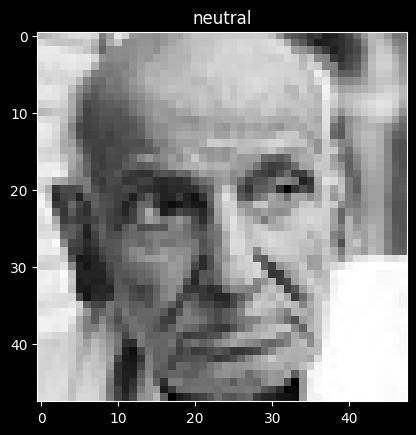

In [11]:
#observations des images
emotions = ['neutral', 'angry', 'fear', 'happy', 'sad', 'surprise', 'disgust']
emotion = 'neutral'
x = random.randint(0, 6)
path = f'data/dataTrain/train/{emotion}/'
img = io.imread(os.path.join(path, random.choice(os.listdir(path))))
plt.imshow(img, cmap='gray')
plt.title(emotion)
# plt.show()

In [12]:
import os

for emotion in os.listdir('data/dataTrain/train'):
    print(emotion, ":", len(os.listdir(os.path.join('data/dataTrain/train', emotion))))


angry : 3995
disgust : 436
fear : 4097
happy : 7215
neutral : 4965
sad : 4830
surprise : 3171


In [13]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 3), # images RGB en niveaux de gris
    transforms.Resize((224, 224)), # redimensionne à 224x224
    transforms.ToTensor(), # convertit en tenseur [0,1]
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)) # normalise entre -1 et 1
])

train_data = datasets.ImageFolder("data/dataTrain/train", transform=transform)
test_data  = datasets.ImageFolder("data/dataTest",  transform=transform)


In [14]:
#80% des données d'entrainement pour l'entrainement et 20% pour validation
train_size = int (0.8 * len(train_data))
validation_size = len(train_data) - train_size
train_dataset, validation_dataset = random_split(train_data, [train_size, validation_size])
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True) #batch size 128 plus rapide

In [15]:
# --- Modèle : ResNet18 fine-tuning ---
modeleEmotions = models.resnet18(pretrained=True)

# Dé-geler uniquement le dernier bloc convolutionnel + fc
for name, param in modeleEmotions.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

nbEmotions = 7
modeleEmotions.fc = nn.Linear(512, nbEmotions)

print(modeleEmotions) # Modèle de classification des émotions


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

C:\Users\kamta\PycharmProjects\PythonProject\HackatonCodeML\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kamta\PycharmProjects\PythonProject\HackatonCodeML\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
#loss function on ne veut pas geler toutes les couches. Sinon, le modele s'ameliore trop lentement
def get_device():
    # NVIDIA GPU (Windows/Linux, parfois Mac via eGPU mais rare)
    if torch.cuda.is_available():
        return torch.device("cuda")
    # Apple Silicon (Mac M1/M2/M3)
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    # Fallback
    return torch.device("cpu")
print(torch.__version__)
device = get_device()
print("Using device:", device)
modeleEmotions = modeleEmotions.to(device)


2.5.1+cu121
Using device: cuda


In [17]:
# --- Optimiseur et scheduler ---
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modeleEmotions.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()
print(torch.backends.mps.is_available())

False


In [18]:
#sanity check
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

outputs = modeleEmotions(images)
print("outputs shape:", outputs.shape)
print("labels shape:", labels.shape)
print("labels dtype:", labels.dtype)
print("labels min/max:", labels.min().item(), labels.max().item())  # doit être 0..6

outputs shape: torch.Size([128, 7])
labels shape: torch.Size([128])
labels dtype: torch.int64
labels min/max: 0 6


In [19]:
num_epochs = 20 # 20 epoch de base pour chaque modification

#fonction principace d'entraiment et de validation
def run_one_epoch(model, loader, training: bool):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.set_grad_enabled(training):
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            if training:
                optimizer.zero_grad()

            outputs = model(images) # (batch, nbEmotions)
            loss = criterion(outputs, labels)

            if training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


# --- Boucle principale ---
for epoch in range(num_epochs):
    train_loss, train_acc = run_one_epoch(modeleEmotions, train_loader, training=True)
    val_loss, val_acc = run_one_epoch(modeleEmotions, validation_loader, training=False)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f} acc {val_acc:.4f}")



Epoch 1/20 | Train loss 1.2837 acc 0.5147 | Val loss 1.1184 acc 0.5803
Epoch 2/20 | Train loss 0.8190 acc 0.7073 | Val loss 1.0900 acc 0.6012
Epoch 3/20 | Train loss 0.4131 acc 0.8826 | Val loss 1.2082 acc 0.6061
Epoch 4/20 | Train loss 0.1183 acc 0.9844 | Val loss 1.3313 acc 0.5951
Epoch 5/20 | Train loss 0.0418 acc 0.9968 | Val loss 1.3678 acc 0.6101
Epoch 6/20 | Train loss 0.0268 acc 0.9974 | Val loss 1.4004 acc 0.6146
Epoch 7/20 | Train loss 0.0181 acc 0.9979 | Val loss 1.4426 acc 0.6149
Epoch 8/20 | Train loss 0.0130 acc 0.9980 | Val loss 1.4691 acc 0.6129
Epoch 9/20 | Train loss 0.0107 acc 0.9979 | Val loss 1.5411 acc 0.6155
Epoch 10/20 | Train loss 0.0080 acc 0.9982 | Val loss 1.5187 acc 0.6144
Epoch 11/20 | Train loss 0.0075 acc 0.9981 | Val loss 1.5518 acc 0.6156
Epoch 12/20 | Train loss 0.0064 acc 0.9979 | Val loss 1.5911 acc 0.6148
Epoch 13/20 | Train loss 0.0057 acc 0.9980 | Val loss 1.6030 acc 0.6196
Epoch 14/20 | Train loss 0.0052 acc 0.9982 | Val loss 1.6673 acc 0.6142
E